# Guidance for Using This Notebook

Welcome to the **Enhance LLMs using RAG and Hugging Face** notebook!

This notebook will guide you through the process of building a Retriever-Augmented Generation (RAG) pipeline using Hugging Face models. You will:

- Install and import all required libraries for NLP and retrieval tasks.
- Download and preprocess a sample company policies dataset.
- Encode documents and questions using Dense Passage Retriever (DPR) models.
- Index document embeddings with FAISS for efficient retrieval.
- Retrieve relevant contexts for a given query.
- Generate answers using a GPT2-based language model, both with and without retrieved context.
- Experiment with generation parameters to observe their effect on answer quality.

## How to Use
- Run each cell sequentially to follow the workflow.
- If you encounter any errors related to missing libraries, re-run the installation cell and restart the kernel.
- You can modify the dataset or queries to experiment with different scenarios.
- Use the exercise section at the end to tune generation parameters and observe their impact.

For more details on each step, refer to the markdown explanations throughout the notebook.

## Install Required Libraries
This cell installs all the necessary Python libraries for the notebook, including packages for downloading files, working with Hugging Face models, PyTorch, FAISS for similarity search, and visualization tools. Run this cell if you haven't already installed these libraries.

In [1]:
!pip install wget transformers datasets torch faiss-cpu matplotlib scikit-learn

## Import Libraries and Suppress Warnings
This cell imports all the required libraries for NLP, retrieval, and visualization. It also sets up warning suppression to keep the notebook output clean.

In [2]:
import wget
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
import torch
import numpy as np
import random
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

# Suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


2025-04-13 18:02:22.621678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744567342.649871     242 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744567342.658187     242 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define t-SNE Visualization Function
This cell defines a helper function to visualize high-dimensional embeddings in 3D using t-SNE. It helps you understand how document embeddings are distributed in space.

In [3]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign colors for each point based on its index
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))
    
    # Plot scatter with unique colors for each point
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])
    
    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

## Download Sample Dataset
This cell downloads a sample company policies dataset using `wget`. The dataset will be used for retrieval and generation tasks.

In [4]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


## Read and Split Dataset into Paragraphs
This cell reads the downloaded text file and splits it into paragraphs. Each paragraph will be treated as a separate document for retrieval.

In [5]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    # Split the text into paragraphs (simple split by newline characters)
    paragraphs = text.split('\n')
    # Filter out any empty paragraphs or undesired entries
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs

# Read the text file and split it into paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

['1.\tCode of Conduct',
 'Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.',
 'Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.',
 "Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.",
 'Accountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potent

## Preview Sample Paragraphs
This cell prints a few sample paragraphs from the dataset to give you an idea of the content.

In [6]:
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



## Load DPR Context Encoder Tokenizer
This cell loads the Dense Passage Retriever (DPR) context encoder tokenizer from Hugging Face. This tokenizer will be used to tokenize the document paragraphs.

In [7]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


## Example Tokenization
This cell tokenizes a sample list of text pairs to show how the tokenizer processes input data.

In [8]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


## Tokenize Texts and Inspect Token IDs
This cell tokenizes the sample texts using the context encoder tokenizer and displays the resulting token IDs.

In [9]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## Convert Token IDs to Tokens
This cell converts the token IDs back to tokens to help you understand how the tokenizer represents the input texts.

In [10]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


## Load DPR Context Encoder Model
This cell loads the DPR context encoder model from Hugging Face. This model will be used to generate embeddings for the document paragraphs.

In [11]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Shuffle Paragraphs
This cell shuffles the paragraphs to ensure that samples are not ordered by category, which helps in unbiased retrieval.

In [12]:
#shuffling samples so that the samples are not ordered based on the category they belong to
random.shuffle(paragraphs)

## Encode Paragraphs and Visualize Embeddings
This cell tokenizes and encodes the first 20 paragraphs, then visualizes their embeddings using the t-SNE plot defined earlier.

In [13]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256) 
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.1054,  0.0770, -0.0520,  ..., -0.5137, -0.6541, -0.0235],
        [ 0.3164, -0.2672,  0.0067,  ...,  0.1750, -0.3381,  0.4668],
        [ 0.5006,  0.3192,  0.3850,  ..., -0.3940, -0.2007,  0.0940],
        ...,
        [ 0.3710,  0.0759, -0.0132,  ..., -0.0757, -0.3577,  0.3237],
        [ 0.2748,  0.4687,  0.3711,  ..., -0.0875, -0.4771,  0.3441],
        [ 0.3210,  0.3423,  0.1777,  ..., -0.1771, -0.5016,  0.2664]],
       grad_fn=<SliceBackward0>)

## Visualize Embeddings in 3D
This cell uses the t-SNE plot function to visualize the 3D distribution of the encoded paragraph embeddings.

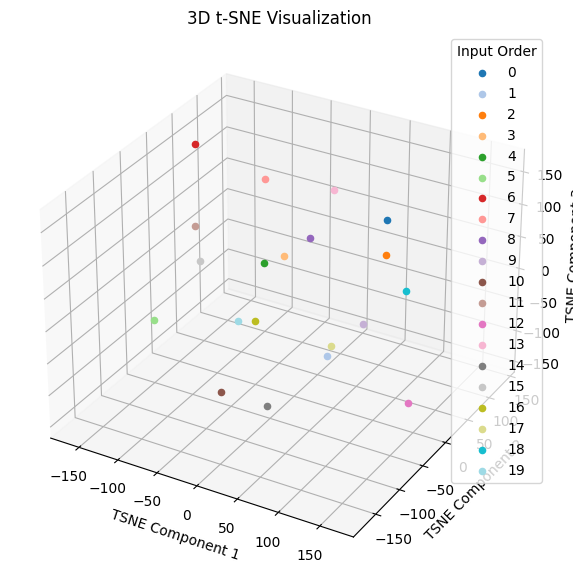

In [14]:
tsne_plot(outputs.pooler_output.detach().numpy())

## Inspect Specific Paragraphs
This cell prints a specific paragraph by its index to examine its content.

In [15]:
print("sample 16:", paragraphs[16])

sample 16: Our Code of Conduct is not just a set of rules; it is the foundation of our organization's culture. We expect all employees to uphold these principles and serve as role models for others, ensuring we maintain our reputation for ethical conduct, integrity, and social responsibility.


## Inspect Another Paragraph
This cell prints another paragraph by its index for further inspection.

In [16]:
print("sample 12:", paragraphs[12])

sample 12: The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.


## Encode and Inspect Embeddings for a Few Paragraphs
This cell encodes the first five paragraphs and inspects the shape and number of generated embeddings.

In [17]:
embeddings=[]
for text in paragraphs[0:5]:
    inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
    outputs = context_encoder(**inputs)
    embeddings.append(outputs.pooler_output)
    print("number of samples:")
    print(len(embeddings))
    print(" samples shape:")
    print(outputs.pooler_output.shape)

number of samples:
1
 samples shape:
torch.Size([1, 768])
number of samples:
2
 samples shape:
torch.Size([1, 768])
number of samples:
3
 samples shape:
torch.Size([1, 768])
number of samples:
4
 samples shape:
torch.Size([1, 768])
number of samples:
5
 samples shape:
torch.Size([1, 768])


## Check Embedding Shape
This cell checks the shape of the concatenated embeddings to ensure they are correctly formed.

In [18]:
torch.cat(embeddings).detach().numpy().shape

(5, 768)

## Encode All Paragraphs
This cell defines a function to encode all paragraphs and generate their embeddings for use in retrieval.

In [19]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()

# you would now encode these paragraphs to create embeddings.
context_embeddings = encode_contexts(paragraphs)

## Create FAISS Index
This cell creates a FAISS index for efficient similarity search over the paragraph embeddings.

In [20]:
import faiss

# Convert list of numpy arrays into a single numpy array
embedding_dim = 768  # This should match the dimension of your embeddings
context_embeddings_np = np.array(context_embeddings).astype('float32')

# Create a FAISS index for the embeddings
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)  # Add the context embeddings to the index

## Load DPR Question Encoder and Tokenizer
This cell loads the DPR question encoder and tokenizer to encode user queries for retrieval.

In [21]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Retrieve Relevant Contexts for a Query
This cell encodes a sample question and retrieves the top 5 most relevant contexts from the FAISS index.

In [22]:
# Example question
question = 'Drug and Alcohol Policy'
question_inputs = question_tokenizer(question, return_tensors='pt')
question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

# Search the index
D, I = index.search(question_embedding, k=5)  # Retrieve top 5 relevant contexts
print("D:",D)
print("I:",I)

D: [[72.76533  74.7162   84.38811  88.364334 90.287094]]
I: [[13 53 63  1 74]]


## Display Top 5 Relevant Contexts
This cell prints the top 5 relevant contexts and their distances to the query embedding.

In [23]:
print("Top 5 relevant contexts:")
for i, idx in enumerate(I[0]):
    print(f"{i+1}: {paragraphs[idx]}")
    print(f"distance {D[0][i]}\n")

Top 5 relevant contexts:
1: 6.	Drug and Alcohol Policy
distance 72.76532745361328

2: Policy Objective: The Drug and Alcohol Policy is established to establish clear expectations and guidelines for the responsible use of drugs and alcohol within the organization. This policy aims to maintain a safe, healthy, and productive workplace.
distance 74.71620178222656

3: Testing and Searches: The organization reserves the right to conduct drug and alcohol testing as per applicable laws and regulations. Employees may be subject to testing in cases of reasonable suspicion, post-accident, or as part of routine workplace safety measures.
distance 84.38810729980469

4: 9.	Discipline and Termination Policy
distance 88.36433410644531

5: Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.
distance 90.28709411621094



## Define Search Function for Relevant Contexts
This cell defines a reusable function to search for the most relevant contexts given a question.

In [24]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    # Tokenize the question
    question_inputs = question_tokenizer(question, return_tensors='pt')

    # Encode the question to get the embedding
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

## Load GPT2 Model and Tokenizer for Generation
This cell loads a GPT2-based language model and tokenizer for answer generation.

In [25]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

## Example Context for Generation
This cell defines a sample context string to test the language model's generation capabilities.

In [26]:
contexts= "What is a large language model?"

## Tokenize Input for Generation
This cell tokenizes the input context for the language model and displays the tokenized output.

In [27]:
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


## Generate Output from Model
This cell generates a summary or answer from the model using the tokenized input.

In [28]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

## Define Function to Generate Answer Without Context
This cell defines a function to generate an answer from the language model using only the question, without any retrieved context.

In [29]:
def generate_answer_without_context(question):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    
    # Generate output directly from the question without additional context
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    
    # Decode and return the generated text
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

## Example: Generate Answer Without Context
This cell uses the function to generate an answer to a sample question without providing any additional context.

In [30]:
# Example usage
question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


## Define Function to Generate Answer With Retrieved Contexts
This cell defines a function to generate an answer using both the question and the top retrieved contexts as input to the language model.

In [31]:
def generate_answer(question, contexts):
    # Concatenate the retrieved contexts to form the input to GPT2
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

## Retrieve Top Contexts for a Question
This cell retrieves the top relevant contexts for a sample question using the search function.

In [32]:
question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)

print(f"paragraphs indexs {I}")

paragraphs indexs [[71 37 74 22 12]]


## Display Top Contexts
This cell prints the top retrieved contexts for the sample question.

In [33]:
top_contexts = [paragraphs[idx] for idx in I[0]] 
print(f"top_contexts {top_contexts}")

top_contexts ['4.\tMobile Phone Policy', 'The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance.', 'Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes.', 'Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations.', 'The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.']


## Generate and Display Answer With Context
This cell generates an answer using the question and the top retrieved contexts, then displays the result.

In [34]:
# Assume `I[0]` contains indices of top contexts from the retrieval step
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta

## Experiment: Tune Generation Parameters
This cell experiments with different generation parameters (max tokens, min length, length penalty, number of beams) to observe their effect on the generated answer quality.

In [ ]:
## Define a function to generate answer with variable parameters
def generate_answer(contexts, max_len=50, min_len=40, length_penalty=2.0, num_beams=4):
    # Concatenate the retrieved contexts to form the input to BAR
    input_text = ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=max_len,
        min_length=min_len,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Define the question
question = "what is mobile policy?"

# Retrieve relevant contexts
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]] 

# Test different generation settings
settings = [
    (50, 50, 1.0, 2),
    (120, 30, 2.0, 4),
    (100, 20, 2.5, 6)
]

# Generate and print answers for each setting
for setting in settings:
    answer = generate_answer(top_contexts, *setting)
    print(f"Settings: max_new_tokens={setting[0]}, min_length={setting[1]}, length_penalty={setting[2]}, num_beams={setting[3]}")
    print("Generated Answer:", answer)
    print("\n" + "="*80 + "\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=50, min_length=50, length_penalty=1.0, num_beams=2
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=120, min_length=30, length_penalty=2.0, num_beams=4
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best 